# Text Classification: SVM Explained
Hello people! Welcome to this kernel. In this kernel I am going to develop a sentiment analyser using **Support Vector Machine** algorithm and **Bag of Words** representation.

Before starting, I have to say that: Using deep learning approachs such as **Recurrent Neural Networks** are better to classify texts, but when we have a small dataset, traditional machine learning may be good.

And if you interested in text classification with traditional machine learning, you might want to use a lazy algorithm to filter spam emails. If you, you can check my **Naive Bayes** kernel. In that kernel I've expalined everything (text processing and deploying a sklearn model included) detailed. Here is the link: https://www.kaggle.com/mehmetlaudatekman/filtering-spam-e-mails-power-of-naive-bayes

# Notebook Content
1. Preparing the Environment
    * Importing Libraries
    * Importing Datasets
1. Simply Explained: Support Vector Machine
1. Data Overview
    * Frequency Distributions with NLTK
1. Data Preprocessing
    * Cleaning Links
    * Cleaning Everything Except Alphabetical and Numerical Characters
    * Tokenizing and Lemmatizing
    * Removing Stopwords
    * Joining Prepared Strings
    * Bag of Words Approach
1. Support Vector Machine Classifier Modeling
    * Fitting SVMC Model with SKLearn
    * Testing Model
1. Conclusion


# Preparing the Environment
In this kernel, I will use **sklearn** to develop a model and vectorize the texts; **nltk** to preprocess texts and data overview.

And I will use several libraries.

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import time
import re

In [ ]:
train_set = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding="latin1")
test_set = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv',encoding="latin1")

train_set.head()

# Simply Explained: Support Vector Machine
Support Vector Machine (after this I will say SVM) is a machine learning approach that has a classifier and regressor, in this section I will cover classifier.

There are versions of SVM such as Linear SVM. In linear SVM, model fits **N** lines to split classes from each other (N is class count - 1 ). We will say **Decision Lines** to these lines. 

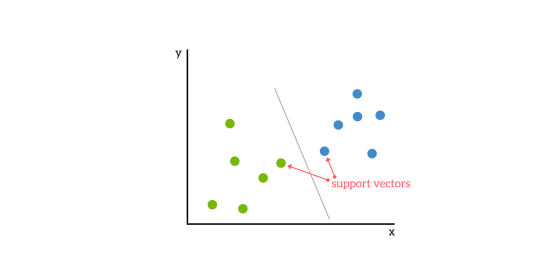

And in order to make classifier durable, **decision line** must be in the closest position to **support points** of each class.

I know, I have not explain what is support point. Support point (also support vectors) is the points that nearest to the decision line. You can see them in the graph above.

And sometimes our dataset may be non-linear. However we can still use SVM to classify non-linear dataset. In order to do this we'll use **kernel tricks**. If we add a new dimension to data we may classify it using lines. Let's take a look at the images below: (thanks for images, here is the link of article [in Turkish])

![](https://miro.medium.com/max/700/1*u7ogmOy2vQDjgw7Pou0hoA.png)

In this example we've added a new dimension (Z) to data and now we can classify it using a line.

Everything you need to know about basics of Support Vector Machine was this. Let's start to implement!

# Data Overview
In this section we will take a look at the data. And in order to do this we will use frequency distrubutions of NLTK.

* First let's drop unrelevant features

In [ ]:
unrelevant_features = ["UserName","ScreenName","Location","TweetAt"]

train_set.drop(unrelevant_features,inplace=True,axis=1)
test_set.drop(unrelevant_features,inplace=True,axis=1)
train_set.head()

* Now let's split sentences as their class, Positive,Neutral and Negative.

In [ ]:
train_set["Sentiment"].value_counts()

In [ ]:
positives = train_set[(train_set["Sentiment"] == "Positive") | (train_set["Sentiment"] == "Extremely Positive")]
positives_test = test_set[(test_set["Sentiment"] == "Positive") | (test_set["Sentiment"] == "Extremely Positive")]
print(positives["Sentiment"].value_counts())
positives.head()


In [ ]:
negatives = train_set[(train_set["Sentiment"] == "Negative") | (train_set["Sentiment"] == "Extremely Negative")]
negatives_test = test_set[(test_set["Sentiment"] == "Negative") | (test_set["Sentiment"] == "Extremely Negative")]
print(negatives["Sentiment"].value_counts())
negatives.head()

In [ ]:
neutrals = train_set[train_set["Sentiment"] == "Neutral"]
neutrals_test = test_set[test_set["Sentiment"] == "Neutral"]
print(neutrals["Sentiment"].value_counts())
neutrals.head()

* Now let's convert labels into integers, I will label negatives as 0, neutrals as 1 and positives as 2.

In [ ]:
import warnings as wrn
wrn.filterwarnings('ignore')

negatives["Sentiment"] = 0 
negatives_test["Sentiment"] = 0

positives["Sentiment"] = 2
positives_test["Sentiment"] = 2

neutrals["Sentiment"] = 1
neutrals_test["Sentiment"] = 1

negatives.head()

* Now I will concatenate train and test, I will split them after processing.

In [ ]:
data = pd.concat([positives,
                  positives_test,
                  neutrals,
                  neutrals_test,
                  negatives,
                  negatives_test
                 ],axis=0)

data.reset_index(inplace=True)

In [ ]:
data.info()

In [ ]:
data.head()

* Finally everything is ready, we can start examining data with examining random texts.

In [ ]:
import random
for i in range(1,10):
    random_ind = random.randint(0,len(data))
    print(str(data["OriginalTweet"][random_ind]),end="\nLabel: ")
    print(str(data["Sentiment"][random_ind]),end="\n\n")


* And let's take a look at the frequency distributions.

In [ ]:
positiveFD = nltk.FreqDist(word for text in data[data["Sentiment"] == 2]["OriginalTweet"] for word in text.lower().split())
negativeFD = nltk.FreqDist(word  for text in data[data["Sentiment"] == 0]["OriginalTweet"] for word in text.lower().split())
neutralDF = nltk.FreqDist(word  for text in data[data["Sentiment"] == 1]["OriginalTweet"] for word in text.lower().split())

* And now we can examine most used words plots.

In [ ]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Positive Tweets")
positiveFD.plot(50)
plt.show()

In [ ]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Negative Tweets")
negativeFD.plot(50)
plt.show()

In [ ]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Neutral Tweets")
neutralDF.plot(50)
plt.show()

* Although most of the words are same (we say them stopwords [words that not have a special meaning]) we can see characteristic words such as **panic**

# Data Preprocessing
In this section we will prepare the dataset in order to use in SVM model. Before starting I want to explain processes with 1 line explanations

* Cleaning Links: We'll clean all website links using regular expressions
* Cleaning Everything Except Alphabetical and Numerical Characters: We'll clean unrelevant digits using regular expressions
* Tokenizing and Lemmatizing: We'll split texts into their words and convert words to their base form (dogs=>dog)
* Removing Stopwords: We'll remove words that have no special meaning (such as **the,will,was**)
* Joining Prepared Strings: We'll join the words
* Bag of Words Approach: We'll create a bag of word. In bag of words approach each feature shows whether the text contains the word or not. For instance if our text contains **grocery** word, its **grocery** feature will be 1 if not it will be 0.

If you want to learn more detail about them, you can check my Naive Bayes text classification kernel. Here is the link: https://www.kaggle.com/mehmetlaudatekman/filtering-spam-e-mails-power-of-naive-bayes

In [ ]:
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data["OriginalTweet"]:
    
    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]
    
    # Joining
    text = " ".join(text)
    
    cleanedData.append(text)

In [ ]:
for i in range(0,5):
    print(cleanedData[i],end="\n\n")

* Now we can create our bag of words, but before starting I want to give an example:

        ====TEXT====           HELLO  WORLD  BRO  CLEAN  SOME  TEXT  WELCOME       
        Hello world               1     1     0     0      0     0      0 
        Hello bro                 1     0     1     0      0     0      0
        Clean some text           0     0     0     1      1     1      0
        You're welcome bro        0     0     1     0      0     0      1
        Welcome to world          0     1     0     0      0     0      1
        
This is a simple bag of words model. 

In [ ]:
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)


* Everything is ready, we can split our set into train and test.

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(BOW,np.asarray(data["Sentiment"]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# Support Vector Machine Classifier Modeling
Everything is ready, now ve can fit our classifier.

In [ ]:
from sklearn.svm import SVC
start_time = time.time()

model = SVC()
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

* It took almost 13 minutes, I hope its worth it.

In [ ]:
predictions = model.predict(x_test)

* Now let's take a look at the accuracy and confusion matrix.

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))

* Our accuracy is 77% Not bad, but I guess we can develop a better model using deep learning.

# Conclusion
Thanks for your attention. In this kernel I have explained what is SVM and how they work and developing a text classifier using SVMs.

If you have any question in your mind, please ask in comment section.

Have a great day!